In [156]:
import numpy as np
import pandas as pd
import datetime
import random
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [157]:
"""
A class that performs as one kind of stocks
"""

class Securities:
#     class level attributes
    
#     Initialized with daily closed price
#     price and shares are the present price and shares to initialized
#     preprice in the price of previous period 
    def __init__(self, name: str, price, shares):
        self.price = price
        self.shares = shares
        self.name = name
        setattr(self, 'preprice', price) # automatically initiate preprice and preshares attributes to calculate gains from this stock
        setattr(self, 'preshares', shares)
        setattr(self, 'modify', 0) # .modify is the attibute that indicate shares to modify
        
    @property
    def price(self):
        return self._price
        
    @price.setter
    def price(self,price):
        if price < 0:
            raise ValueError("Price of securities cannot be negative")
        self._price = price
        
# -----------------------------------------------------------------------
# setting methods
    def reset(self, new_price, shares_to_modify):
        self.preshares = self.shares
        if shares_to_modify < 0:
            if -shares_to_modify > self.shares:
                raise ValueError('Can not sell more shares than you have')
            else:
                self.shares += shares_to_modify
        else:
            self.shares += shares_to_modify
        self.preprice = self.price
        self.price = new_price
        self.modify = shares_to_modify
        
#     .gains() returns the total gains(or losses) from selling(or buying) certain shares of stock at the present price
    def gains(self):
        if self.modify == 0:
            raise ValueError('None shares need to modify.')
        shares_to_modify = -self.modify
        self.modify = 0 # important! reset the .modify attribute to be 0
        return self.price * shares_to_modify

In [158]:
"""
A class that performs as a securities account
"""
class Account:
#     class level attributes
    INITCASH = 100000
    Tax = 0.25
    
#     stocks are one or several Securities objects
#     marval -- market value of the portfolio
    def __init__(self,*stocks):
        values = [*stocks] # portfoio of this account
        keys = [y.name for y in [*stocks]] # list of stocks' name in portfolio
        self.port = dict(zip(keys, values))
        marval = sum([y.price*y.shares for y in [*stocks]])
        if marval > self.INITCASH:
            raise ValueError('Cannot initiate account with total market value more than initial cash')
        else:
            setattr(self, 'cashleft', self.INITCASH - marval)
            setattr(self, 'cashpool', self.INITCASH - marval)
    
#     Attribute that prevent trading from going on when it encounters huge losses
    @property
    def cashleft(self):
        return self._cashleft
    
    @cashleft.setter
    def cashleft(self, cash):
        if cash < 0:
            raise ValueError('Cash in the account cannot be negative!')
        else:
            self._cashleft = cash
    
# -------------------------------------------------------------------------
# Start setting methods

#     update the market value in time
    @property
    def marval(self):
        marval = sum([x.price*x.shares for x in self.port.values()])
        return marval
    
    def __repr__(self):
        print("stock name | present price | present position")
        for stock_name in self.port.keys():
            print(f"{stock_name} \t\t {self.port[stock_name].price} \t\t {self.port[stock_name].shares}")
        return f'present market value: {self.marval}'
        
# The reallocation method will take a dict as input 
# The dict looks like {'AAPL':(10,0),'GOOGL':(12,100),'ORCL':(7.5,-100),...}, 
# keys of the dict are names of stocks to modify, for the dict-value tuple the first element is the new price and the second one is shares to modify
# The method has 3 functions:
#                             reset every Securities object that is to be modified
#                             calculate the gains and losses of the account
#                             calculate the yield of portfolio
    # adjusts is a list of daily shares and price adjustment
    def sell(self, adjusts: dict): 
        adjprice = dict(zip([x for x in adjusts.keys()], 
                            [y[0] for y in adjusts.values()]))
        adjshares = dict(zip([x for x in adjusts.keys()], 
                             [y[1] for y in adjusts.values()]))
        for adjust in adjshares.values():
            if adjust >= 0:
                raise ValueError('Shares to modify in the to-sell list must be negative!')
        for stock in adjusts.keys():
            if stock not in self.port.keys():
                raise ValueError('Illegal adjustment! Can not sell stocks not in the portfolio')

#          sell out all the stock in the to-sell list and cauculate gains
        for stock_name in adjusts.keys():
            new_price = adjprice[stock_name]
            shares_to_modify = adjshares[stock_name]
            stock = self.port[stock_name] # stock is a Securities object
            stock.reset(new_price, shares_to_modify)  # important command to reset stock
            gains = stock.gains()
#             This is the objective execution of this function 
            self.cashpool += gains # gains cash from selling stocks in the to-sell list
        soldout = list(stock for stock in self.port.values())
        for stock in soldout: # remove the stocks whose position have been closed from the portfolio
                if stock.shares == 0:
                    del self.port[stock.name]
        setattr(self, 'havesell', True)
    
    def buy(self, adjusts: dict):
        if not self.havesell:
            raise ValueError('You must sell some securities first obtaining some cash to support trading!')
        adjprice = dict(zip([x for x in adjusts.keys()], 
                            [y[0] for y in adjusts.values()]))
        adjshares = dict(zip([x for x in adjusts.keys()], 
                             [y[1] for y in adjusts.values()]))
        for stock_name in adjusts.keys():
            if adjshares[stock_name] <= 0:
                raise ValueError('Shares in the adjusts must be positive!')
            if stock_name not in self.port.keys():
                new_stock = Securities(stock_name, 
                                       adjprice[stock_name],
                                       0)
                self.port[stock_name] = new_stock
            stock = self.port[stock_name]
            new_price = adjprice[stock_name]
            modify = adjshares[stock_name]
            stock.reset(new_price, modify)
            gains = stock.gains()
            if self.cashpool + gains < 0:
                raise ValueError('Cannot use more money than cash pool!')
            self.cashpool += gains
        self.cashleft = self.cashpool
        self.havesell = False

In [159]:
### sample test
df = pd.read_csv('SampleData.csv')

Preprocessing

In [160]:
def preprocess(df):
    if df.isnull().values.any():
        raise ValueError('Exist NaN Value!')
    else:
        df.set_index('Date', inplace = True)

    #     create market value(Mkt) columns by price_column * volume_column

    #     first generate Mkt numpy arrays
        close = list()
        volume = list()
        for column in df.columns:
            pattern_C = r"[a-zA-Z-]+_Close$"
            pattern_V = r"[a-zA-Z-]+_Volume$"
            match_c = re.findall(pattern_C, column)
            match_v = re.findall(pattern_V, column)
            close += match_c
            volume += match_v

        for x in [*zip(close, volume)]:
            _close = x[0]
            _volume = x[1]
            name = _close.split("_")[0]
            df[name + "_Mkt"] = np.array(df[_close]) * np.array(df[_volume])

    #     then, generate Mkt columns using Mkt numpy arrays
        s = list() # s is the list of Mkt columns name
        for x in df.columns.tolist():
            p = r"[a-zA-Z-]+_Mkt$"
            match = re.findall(p,x)
            s += match

        small_ = df[s]
        small_np = np.array(small_)
        small_np = small_np.T
        small_df = pd.DataFrame(small_np, index=small_.columns.tolist(), columns=small_.index.tolist())
        global small
        small = small_df

In [161]:
preprocess(df)
small

,2016-11-21,2016-11-22,2016-11-23,2016-11-25,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-05,...,2018-11-07,2018-11-08,2018-11-09,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-19,2018-11-20
AAPL_Mkt,3.269734e+09,2.902943e+09,3.050639e+09,1.282891e+09,3.034035e+09,3.179820e+09,3.996657e+09,4.060645e+09,2.915427e+09,3.745146e+09,...,7.017453e+09,5.287849e+09,7.026775e+09,9.928980e+09,9.012300e+09,1.135763e+10,8.896507e+09,7.146734e+09,7.792236e+09,1.200370e+10
ABEV_Mkt,5.575079e+07,1.188159e+08,1.098387e+08,3.630026e+07,1.133510e+08,1.982243e+08,1.497399e+08,2.441394e+08,1.728266e+08,6.374932e+07,...,1.185148e+08,1.215498e+08,1.574990e+08,5.567379e+07,8.513783e+07,1.115885e+08,7.383042e+07,9.543595e+07,7.982551e+07,8.066271e+07
AMD_Mkt,5.864273e+08,6.197082e+08,3.043322e+08,1.246577e+08,2.287659e+08,4.896444e+08,3.253210e+08,4.755653e+08,3.616626e+08,2.726397e+08,...,2.645169e+09,1.958617e+09,1.806492e+09,1.825894e+09,1.492831e+09,2.213025e+09,2.099906e+09,2.321701e+09,1.788279e+09,2.110591e+09
AMRN_Mkt,7.136749e+06,6.894862e+06,6.513104e+06,2.585520e+06,5.819282e+06,5.034841e+06,6.505920e+06,6.963572e+06,3.822069e+06,4.038488e+06,...,1.789185e+08,1.690602e+08,2.544187e+08,7.733724e+08,5.445535e+08,4.958222e+08,4.208996e+08,2.320441e+08,1.332001e+08,1.256529e+08
BAC_Mkt,2.388350e+09,2.126867e+09,2.278075e+09,1.306053e+09,2.205619e+09,2.317459e+09,4.048696e+09,4.283529e+09,2.727391e+09,2.847440e+09,...,1.617624e+09,1.426790e+09,1.234078e+09,1.396033e+09,1.594074e+09,1.883294e+09,1.846277e+09,1.455657e+09,1.276500e+09,2.528012e+09
CHK_Mkt,3.359492e+08,2.743247e+08,2.887524e+08,1.374878e+08,2.964958e+08,3.257822e+08,8.560965e+08,7.675878e+08,3.699020e+08,4.471432e+08,...,9.882440e+07,9.866511e+07,1.343209e+08,1.040927e+08,1.502979e+08,1.707735e+08,1.041513e+08,1.185238e+08,9.907769e+07,1.396355e+08
CSCO_Mkt,8.258251e+08,8.001344e+08,7.236851e+08,5.319581e+08,6.423495e+08,7.026069e+08,7.820265e+08,7.655881e+08,7.917829e+08,6.161671e+08,...,9.575402e+08,1.017337e+09,1.037146e+09,1.182174e+09,1.181995e+09,1.623077e+09,2.150639e+09,1.452025e+09,1.297946e+09,1.264877e+09
ECA_Mkt,1.499480e+08,1.426607e+08,1.649722e+08,5.825005e+07,1.290370e+08,1.589575e+08,3.704778e+08,3.014725e+08,3.668044e+08,1.291647e+08,...,4.032110e+08,3.547235e+08,2.799158e+08,2.378499e+08,3.745545e+08,4.189965e+08,3.337114e+08,2.854277e+08,2.042295e+08,2.271322e+08
F_Mkt,2.300064e+08,2.886262e+08,2.667266e+08,1.377328e+08,2.909338e+08,2.823943e+08,5.698486e+08,1.182635e+09,4.735632e+08,4.505768e+08,...,3.585350e+08,5.279635e+08,4.896698e+08,3.446502e+08,3.157549e+08,4.453043e+08,5.322536e+08,4.939716e+08,5.207056e+08,3.185487e+08
FB_Mkt,4.312533e+09,3.169055e+09,1.893817e+09,1.042322e+09,2.179578e+09,2.283355e+09,3.574969e+09,4.981183e+09,2.893124e+09,2.372262e+09,...,3.315082e+09,3.570439e+09,2.511708e+09,2.624634e+09,2.152544e+09,3.182705e+09,4.361575e+09,5.197576e+09,5.835913e+09,5.554048e+09


In [162]:
### create returns 
columns = small.columns.tolist()
for i in columns[0:504]:
    index = columns.index(i)
    small[str(i) + '_' + 'returns'] = (small[small.columns[index+1]] - small[small.columns[index]]) / small[small.columns[index]]
    returns = small.iloc[:, 504:]# use market values to calculate returns every day
    returns.columns = [str(i).split("_")[0] for i in df_returns.columns.tolist()]
returns

ValueError: Length mismatch: Expected axis has 1 elements, new values have 504 elements

Initiate Trading

In [51]:
### function to get the initial basket from date x ###
def initial_day(df, returns, x, cashpool, stocknum):
    position = returns.columns.tolist().index(x) # get the column index of the date x input
    returns = returns.sort_values([x],ascending=False) # sort according to date x
    choice = np.array(returns.index[0:stocknum]).tolist() # get the smallest N(5) stocks of the day
    choice = [i.split('_')[0] for i in choice]

    # get the column name I want to find the close price for each stock on day x
    price = [i.split('_')[0] + "_" + 'Close' for i in choice]

    # find the close price for each stock on day x
    close = []
    for i in range(len(price)):
        b = df.loc[x, price[i]]
        close.append(b)
        invest = cashpool / stocknum
        share = [int(invest / i) for i in close]
        buy_dict = dict(zip(choice, share)) # update buy_list for INITIAL day x
    return buy_dict

In [128]:
init_dict = initial_day(df, returns, '2016-11-21', 100000, 5)
init_dict

{'X': 694, 'ABEV': 3861, 'PCG': 338, 'VALE': 2610, 'INTC': 571}

In [119]:
# Switch the format of function: initial_day and second_day
# original format is {stock_name: shares_to_adjust}
# updated format is {stock_name: (present_price, shares_to_adjust)}
def transform(df, adjdict, date):
    output = dict()
    for stock_name in adjdict.keys():
        column = stock_name + "_Close"
        price = df.loc[date, column]
        output_value = (price, adjdict[stock_name])
        output[stock_name] = output_value
    return output

In [120]:
initdict = transform(df,init_dict,'2016-11-21')

In [121]:
initdict

{'X': (28.780001, 694),
 'ABEV': (5.18, 3861),
 'PCG': (59.16, 338),
 'VALE': (7.66, 2610),
 'INTC': (34.98, 571)}

# initiate Securities Object and Account Object
def initiate(init_dict):
    prepare_for_account = dict()
    
#     initiate all stocks
    for stock_name in init_dict.keys():
        prepare_for_account[stock_name] = Securities(stock_name,
                                                     init_dict[stock_name][0],
                                                     init_dict[stock_name][1])
#         initiate the stocks account
    account = Account(*prepare_for_account.values())
    return account

In [122]:
account = initiate(initdict)

Reallocate assets given trade date and present portfolio

In [154]:
def reallocation(account, df, returns, y): # date x -- enter stock market; y- date want to make change
    buy_dict = dict()
    
#     munipulate date time
    date_list = df.index.tolist()
    delta = datetime.timedelta(days = 1)
    today = datetime.datetime.strptime(y,'%Y-%m-%d')
    delta = datetime.timedelta(days = 1)
    x = datetime.date.strftime(today - delta, "%Y-%m-%d")
    while x not in date_list:
        x_day = datetime.datetime.strptime(x,'%Y-%m-%d')
        x = datetime.date.strftime(x_day - delta, "%Y-%m-%d")
    
    position = returns.columns.tolist().index(x) # get the column index of the date x input
    returns1 = returns.sort_values([x],ascending=False) # sort according to date x
    choice = np.array(returns1.index[0:5]).tolist() # get the smallest N(30) stocks of the day
    choice = [i.split('_')[0] for i in choice] # stock_name list of the least 30 market value 
    for name in choice:
        if name not in account.port.keys():
            raise ValueError("Portfolio in the previous trading day is not in accordance with the Account object, You might have skipped some dates.")
    
    def new_basket(returns, y): # given day y - that we want to get portfolio change
        position = returns.columns.tolist().index(y) # get the column index of second day of the date x input
        returns2 = returns.sort_values([y],ascending=False) # sort according to date x
        choice2 = np.array(returns2.index[0:5]).tolist() # get the smallest N(5) stocks of the second day
        choice2 = [i.split('_')[0] for i in choice2]
        ones = np.ones(5, dtype=int) # give all 1 to  to buy for each stock
        a = dict(zip(choice2, ones)) # buy basket for date y
        return a

    ### FINALIZED 3 dicts to return at the end ###
    new = new_basket(returns,y) #today
    sell = dict()
    keep = dict()
    buy = dict()
    for name in new:
        if name not in choice:
            buy[name] = 1
        else:
            keep[name] = 0
    for name in choice:
        if name not in new.keys():
            sell[name] = -account.port[name].shares

    return (buy, keep, sell)

In [155]:
buy,keep,sell = reallocation(account, df, returns, '2016-11-22')

ValueError: Portfolio in the previous trading day is not in accordance with the Account object, You might have skipped some dates.

In [134]:
buy

{'FCX': 1, 'ECA': 1, 'BAC': 1, 'CHK': 1, 'AAPL': 1}

In [135]:
sell

{'X': -694, 'ABEV': -3861, 'PCG': -338, 'VALE': -2610, 'INTC': -571}

In [136]:
sell_dict = transform(df, sell, '2016-11-22')
sell_dict

{'X': (32.209999, -694),
 'ABEV': (5.06, -3861),
 'PCG': (59.32, -338),
 'VALE': (8.29, -2610),
 'INTC': (35.48, -571)}

In [137]:
account.sell(sell_dict)

In [138]:
cash = account.cashpool

Given a buy list return a buy dict that can be passed into .buy method

In [139]:
def pretrade(df,buy,cash,date):
    import random
    long = buy
    assert len(long) < 30 # the securities pool of this strategy is 30
    percash = cash/len(long)
    for stock_name in long:
        price = df.loc[date, stock_name+"_Close"]
        long[stock_name] = (price, round(percash/price))
    if sum([*zip(*long.values())][1]) > cash: # this sum function computes the total present value after rounding
        stock_name = [*long.keys()][random.randint(0,len(long)-1)]
        long[stock_name] = (long[stock_name][0], long[stock_name][1]-1) # randomly select one stock and subtract 1 from its shares
    return long

In [140]:
buy_dict = pretrade(df,buy,cash,'2016-11-22')

In [141]:
buy_dict

{'FCX': (15.12, 1374.0),
 'ECA': (12.18, 1706.0),
 'BAC': (20.299999, 1024.0),
 'CHK': (6.44, 3227.0),
 'AAPL': (111.800003, 186.0)}

In [142]:
account.buy(buy_dict)

ValueError: Cannot use more money than cash pool!

In [143]:
keep

{}

reset the price of stocks that kept position

In [144]:
def keepposition(df,keep,date,account):
    for stock_name in keep:
        if stock_name not in account.port:
            raise ValueError('Keep list is not in accordance with present portfolio!')
        column = stock_name + "_Close"
        price = df.loc[date, column]
        stock = account.port[stock_name]
        stock.reset(price, 0)

In [145]:
keepposition(df,keep,'2016-11-22',account)

In [146]:
account

stock name | present price | present position
FCX 		 15.12 		 1374.0
ECA 		 12.18 		 1706.0
BAC 		 20.299999 		 1024.0
CHK 		 6.44 		 3227.0
AAPL 		 111.800003 		 186.0


present market value: 103917.839534

# Begin the whole trading now!

In [147]:
def trading(df,returns):
    initial = initial_day(df, returns, '2016-11-21', 100000, 5)
    init_basket = transform(df,initial,'2016-11-21')
    account = initiate(initdict)
    pv_ = list()
    
    for date in df.index.tolist()[1:]: #exceping the initial date
        buy, keep, sell = reallocation(account, df, returns, date) 
        sell_dict = transform(df,sell,date)
        buy_dict = transform(df,buy,date)
        account.sell(sell_dict)
        account.buy(buy_dict)
        keepposition(df,keep,date,account)
        value = account.marval + account.cashleft
        pv_.append(value)
    
    pv = account.marval + account.cashleft
    
    return pv, pv_

In [148]:
pv, pv_list = trading(df, returns)

In [149]:
pv

103895.39861599974

In [150]:
pv_list.insert(0,100000)

In [151]:
df['total_pv'] = pv_list

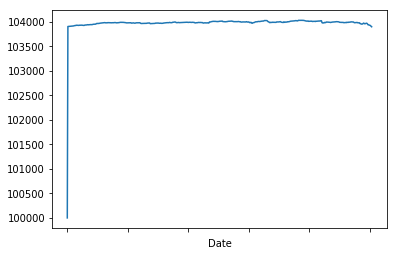

In [152]:
yield_curve = df['total_pv'].plot(x=df.index, kind='line')

In [153]:
fig = yield_curve.get_figure()
fig.savefig('yield.jpg')